<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v3.0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [35]:
## section: Data manioulation
import pandas as pd
import numpy as np
import random
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [60]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  worker = 4
else:
  worker = 0
print('Using device:', device, 'Using number of workers: ', worker)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Using device: cuda Using number of workers:  4

Tesla T4
Memory Usage:
Allocated: 0.6 GB
Cached:    0.7 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [37]:
## Download from cifar10
dataset = 'cifar10' # change this one
set_seed(1311)
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 4
Preview Images with Label : truck
Show of images unique 10 labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


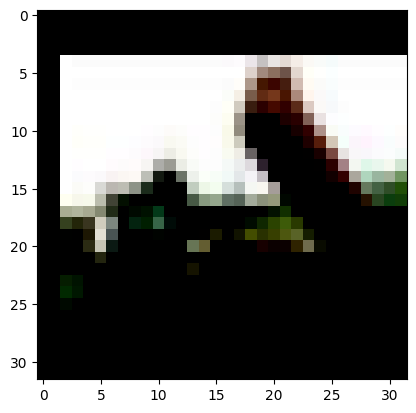

In [38]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
num_class = len(classes)
print(f"Show of images unique {num_class} labels: ",classes)


### Tranforms to Dataloader

In [25]:
batch_size = 32

## setting the split configuration
set_seed(1311)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, val_data = random_split(training_data, [train_size, val_size])

## apply the dataloader
set_seed(1311)

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )

# check the splitting
num_items_train = len(trainloader.dataset)
num_items_val = len(valloader.dataset)
num_items_test = len(testloader.dataset)

num_batches_train = len(trainloader)
num_batches_val = len(valloader)
num_batches_test = len(testloader)

print("Training set: {} items, {} batches".format(num_items_train, num_batches_train))
print("Validation set: {} items, {} batches".format(num_items_val, num_batches_val))
print("Test set: {} items, {} batches".format(num_items_test, num_batches_test))

Training set: 13107 items, 410 batches
Validation set: 3277 items, 103 batches
Test set: 10000 items, 313 batches


### Review the Batch fig and size

torch.Size([32, 3, 32, 32])


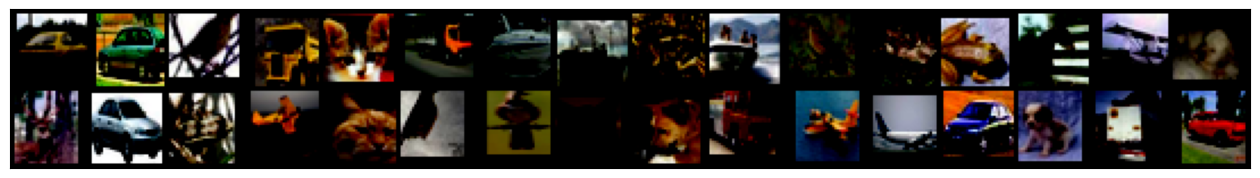

In [26]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [ ]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311, num_class = num_class):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()

    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)



                if epoch + 1 == num_epochs:
                  # class_correct = list(0. for i in range(num_class))
                  # class_total = list(0. for i in range(num_class))
                  c = (preds == labels).squeeze()
                  for i in range(labels.size(0)):
                      label = labels[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1



        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

        if epoch + 1 == num_epochs:
          print('Accuracy for each class')
          for i in range(num_class):
            # print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            if class_total[i] > 0:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            else:
                print('Accuracy of %5s : N/A (no training examples)' % (classes[i]))

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy




In [77]:
import time
from tqdm import tqdm

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    loss = running_loss / total
    accuracy = correct.double() / total
    return loss, accuracy


def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, device, num_class, model_name, dataset):
    set_seed(1311)
    ## Set up the path for saving the model
    PATH = f'./{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## Initialize variables
    best_val_acc = 0  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, valloader, criterion, device)


        # Step the scheduler with the validation loss
        # scheduler.step()
        scheduler.step(val_acc) # for ReduceLROnPlateau

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(100 * val_acc)

        # Save the model if it has improved on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')

        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    print('Training complete. Evaluating on test set with the best model...')

    # Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    test_loss, test_acc = evaluate(best_model, testloader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {100 * test_acc:.2f}%')

    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = 100 * test_acc

    return history

## Initialize network

### network: workshop CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=num_class):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if num_class == 10:
          self.fc1 = nn.Linear(16 * 5 * 5, 120)
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, num_class)
        else:
          self.fc1 = nn.Linear(16 * 5 * 5, 200)
          self.fc2 = nn.Linear(200, 120)
          self.fc3 = nn.Linear(120, num_class)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### network: SimpleCNN

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [53]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [56]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [49]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_acc(train_acc, val_acc):
    if isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.cpu().numpy() for x in train_acc]
    if isinstance(val_acc[0], torch.Tensor):
        val_acc = [x.cpu().numpy() for x in val_acc]

    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [62]:
# set the whole network training
num_epochs = 50
criterion = nn.CrossEntropyLoss()

### Train the network - net

In [ ]:
# # individual configuration
# net = Net().to(device)
# model = net
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# # training model
# net_results = train_network(model,
#                             optimizer,
#                             criterion,
#                             trainloader,
#                             testloader,
#                             num_epochs
#                             )

# # plot the chart
# plot_loss(net_results[0], net_results[2])
# plot_acc(net_results[1], net_results[3])

# # save the model info
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)


### Train the network - simpleCNN

In [ ]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
simplecnn_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(simplecnn_results['train_loss'], simplecnn_results['val_loss'])
plot_acc(simplecnn_results['train_accuracy'], simplecnn_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {simplecnn_results["test_loss"]:.4f}, Test Accuracy: {simplecnn_results["test_accuracy"]:.2f}%')

Model will be saved to: ./cifar10_simplecnn.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 103/103 [00:01<00:00, 62.19it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 1/50, Train Loss: 2.0370, Train Acc: 24.03%, Val Loss: 1.7966, Val Acc: 33.05%, Time: 8.82s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.05it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 2/50, Train Loss: 1.6695, Train Acc: 38.49%, Val Loss: 1.6308, Val Acc: 38.69%, Time: 7.78s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.18it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 3/50, Train Loss: 1.4982, Train Acc: 45.22%, Val Loss: 1.4283, Val Acc: 48.61%, Time: 8.85s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 62.91it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 4/50, Train Loss: 1.3856, Train Acc: 49.80%, Val Loss: 1.3739, Val Acc: 51.02%, Time: 8.90s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.81it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 5/50, Train Loss: 1.2990, Train Acc: 52.46%, Val Loss: 1.2409, Val Acc: 55.75%, Time: 7.73s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.45it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 6/50, Train Loss: 1.1955, Train Acc: 57.23%, Val Loss: 1.1428, Val Acc: 58.86%, Time: 8.92s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.36it/s]


Epoch 7/50, Train Loss: 1.1262, Train Acc: 59.53%, Val Loss: 1.1615, Val Acc: 57.83%, Time: 9.00s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.01it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 8/50, Train Loss: 1.0601, Train Acc: 62.29%, Val Loss: 1.0639, Val Acc: 62.13%, Time: 7.78s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.36it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 9/50, Train Loss: 0.9907, Train Acc: 64.86%, Val Loss: 1.0320, Val Acc: 63.66%, Time: 8.70s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 62.01it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 10/50, Train Loss: 0.9499, Train Acc: 66.59%, Val Loss: 0.9662, Val Acc: 66.28%, Time: 8.89s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.30it/s]


Epoch 11/50, Train Loss: 0.8989, Train Acc: 68.01%, Val Loss: 0.9817, Val Acc: 65.09%, Time: 7.78s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.80it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 12/50, Train Loss: 0.8671, Train Acc: 69.21%, Val Loss: 0.9413, Val Acc: 66.31%, Time: 8.81s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 56.40it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 13/50, Train Loss: 0.8246, Train Acc: 71.01%, Val Loss: 0.8764, Val Acc: 68.87%, Time: 8.77s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.26it/s]


Epoch 14/50, Train Loss: 0.7913, Train Acc: 72.62%, Val Loss: 0.8892, Val Acc: 68.66%, Time: 8.02s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.57it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 15/50, Train Loss: 0.7650, Train Acc: 73.28%, Val Loss: 0.9032, Val Acc: 69.39%, Time: 8.72s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 63.58it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 16/50, Train Loss: 0.7351, Train Acc: 74.26%, Val Loss: 0.8511, Val Acc: 70.43%, Time: 8.77s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 63.78it/s]


Epoch 17/50, Train Loss: 0.7020, Train Acc: 75.15%, Val Loss: 0.8940, Val Acc: 69.18%, Time: 7.85s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.15it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 18/50, Train Loss: 0.6817, Train Acc: 75.76%, Val Loss: 0.8157, Val Acc: 71.35%, Time: 8.95s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.62it/s]


Epoch 19/50, Train Loss: 0.6677, Train Acc: 76.26%, Val Loss: 0.8674, Val Acc: 69.61%, Time: 9.92s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.31it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 20/50, Train Loss: 0.6352, Train Acc: 77.85%, Val Loss: 0.8239, Val Acc: 71.93%, Time: 7.82s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.08it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 21/50, Train Loss: 0.6234, Train Acc: 78.19%, Val Loss: 0.8226, Val Acc: 72.63%, Time: 8.86s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.18it/s]


Epoch 22/50, Train Loss: 0.5893, Train Acc: 79.36%, Val Loss: 0.8111, Val Acc: 71.74%, Time: 8.70s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.94it/s]


Epoch 23/50, Train Loss: 0.5748, Train Acc: 79.50%, Val Loss: 0.8823, Val Acc: 71.13%, Time: 7.71s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.51it/s]


Epoch 24/50, Train Loss: 0.5624, Train Acc: 80.31%, Val Loss: 0.8545, Val Acc: 72.14%, Time: 8.85s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.50it/s]


Epoch 25/50, Train Loss: 0.5397, Train Acc: 81.29%, Val Loss: 0.8535, Val Acc: 72.29%, Time: 8.77s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.58it/s]


Epoch 26/50, Train Loss: 0.5248, Train Acc: 81.26%, Val Loss: 0.8576, Val Acc: 72.20%, Time: 7.82s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.65it/s]


Epoch 27/50, Train Loss: 0.5114, Train Acc: 81.75%, Val Loss: 0.8685, Val Acc: 71.90%, Time: 8.73s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.63it/s]


Epoch 28/50, Train Loss: 0.4978, Train Acc: 82.61%, Val Loss: 0.9011, Val Acc: 71.90%, Time: 8.95s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.52it/s]


Epoch 29/50, Train Loss: 0.4976, Train Acc: 82.54%, Val Loss: 0.9221, Val Acc: 71.01%, Time: 7.69s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.26it/s]


Epoch 30/50, Train Loss: 0.4727, Train Acc: 83.40%, Val Loss: 0.8853, Val Acc: 71.71%, Time: 8.80s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 60.24it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 31/50, Train Loss: 0.4619, Train Acc: 83.73%, Val Loss: 0.8477, Val Acc: 73.24%, Time: 9.13s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 55.23it/s]


Epoch 32/50, Train Loss: 0.4418, Train Acc: 84.58%, Val Loss: 0.9672, Val Acc: 70.98%, Time: 8.45s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 65.01it/s]


Epoch 33/50, Train Loss: 0.4374, Train Acc: 84.65%, Val Loss: 0.9234, Val Acc: 72.69%, Time: 8.68s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.01it/s]


Epoch 34/50, Train Loss: 0.4240, Train Acc: 85.36%, Val Loss: 0.8979, Val Acc: 72.90%, Time: 8.85s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 47.93it/s]


Epoch 35/50, Train Loss: 0.4194, Train Acc: 85.33%, Val Loss: 0.9362, Val Acc: 71.68%, Time: 8.56s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.13it/s]


Epoch 36/50, Train Loss: 0.4302, Train Acc: 85.08%, Val Loss: 0.9368, Val Acc: 72.90%, Time: 8.21s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.45it/s]


Epoch 37/50, Train Loss: 0.3947, Train Acc: 86.30%, Val Loss: 0.9150, Val Acc: 72.47%, Time: 8.81s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 55.74it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 38/50, Train Loss: 0.3821, Train Acc: 86.64%, Val Loss: 0.8876, Val Acc: 74.21%, Time: 8.07s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 65.98it/s]


Epoch 39/50, Train Loss: 0.3793, Train Acc: 86.55%, Val Loss: 0.9270, Val Acc: 72.75%, Time: 8.52s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.20it/s]


Epoch 40/50, Train Loss: 0.3655, Train Acc: 87.29%, Val Loss: 0.9438, Val Acc: 73.21%, Time: 8.89s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 50.75it/s]


Epoch 41/50, Train Loss: 0.3547, Train Acc: 87.78%, Val Loss: 0.9260, Val Acc: 74.15%, Time: 8.26s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.05it/s]


Epoch 42/50, Train Loss: 0.3504, Train Acc: 87.80%, Val Loss: 0.9071, Val Acc: 74.15%, Time: 8.47s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.81it/s]


Epoch 43/50, Train Loss: 0.3502, Train Acc: 87.48%, Val Loss: 0.9510, Val Acc: 73.63%, Time: 8.90s


Training:  11%|█         | 46/410 [00:00<00:05, 65.10it/s]

Model will be saved to: ./cifar10_simplecnn.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.26it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 1/50, Train Loss: 1.8993, Train Acc: 29.95%, Val Loss: 1.6895, Val Acc: 37.38%, Time: 8.72s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 59.20it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 2/50, Train Loss: 1.5654, Train Acc: 42.40%, Val Loss: 1.5631, Val Acc: 42.45%, Time: 8.81s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.06it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 3/50, Train Loss: 1.4615, Train Acc: 46.53%, Val Loss: 1.4372, Val Acc: 49.19%, Time: 7.84s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.91it/s]


Epoch 4/50, Train Loss: 1.3866, Train Acc: 49.81%, Val Loss: 1.3849, Val Acc: 48.18%, Time: 8.67s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.29it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 5/50, Train Loss: 1.3381, Train Acc: 51.45%, Val Loss: 1.3029, Val Acc: 53.28%, Time: 8.78s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.60it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 6/50, Train Loss: 1.2665, Train Acc: 54.03%, Val Loss: 1.2773, Val Acc: 54.01%, Time: 7.80s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 70.49it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 7/50, Train Loss: 1.2189, Train Acc: 56.16%, Val Loss: 1.2211, Val Acc: 56.30%, Time: 8.80s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.44it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 8/50, Train Loss: 1.1681, Train Acc: 57.80%, Val Loss: 1.1824, Val Acc: 57.31%, Time: 8.86s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 65.53it/s]


Epoch 9/50, Train Loss: 1.1232, Train Acc: 60.20%, Val Loss: 1.1749, Val Acc: 56.39%, Time: 7.79s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.97it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 10/50, Train Loss: 1.0717, Train Acc: 61.45%, Val Loss: 1.0932, Val Acc: 60.60%, Time: 8.74s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.81it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 11/50, Train Loss: 1.0569, Train Acc: 62.51%, Val Loss: 1.0449, Val Acc: 62.13%, Time: 9.63s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.39it/s]


Epoch 12/50, Train Loss: 1.0105, Train Acc: 64.10%, Val Loss: 1.0533, Val Acc: 62.10%, Time: 7.80s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.39it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 13/50, Train Loss: 0.9797, Train Acc: 65.06%, Val Loss: 0.9879, Val Acc: 65.00%, Time: 8.88s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.92it/s]


Epoch 14/50, Train Loss: 0.9537, Train Acc: 66.16%, Val Loss: 0.9779, Val Acc: 64.94%, Time: 8.86s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 53.41it/s]


Epoch 15/50, Train Loss: 0.9223, Train Acc: 67.17%, Val Loss: 0.9849, Val Acc: 64.24%, Time: 9.22s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 45.41it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 16/50, Train Loss: 0.9056, Train Acc: 67.87%, Val Loss: 0.9553, Val Acc: 65.49%, Time: 12.03s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.81it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 17/50, Train Loss: 0.8842, Train Acc: 68.24%, Val Loss: 0.9520, Val Acc: 66.13%, Time: 9.30s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 47.66it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 18/50, Train Loss: 0.8608, Train Acc: 69.82%, Val Loss: 0.8911, Val Acc: 68.60%, Time: 12.68s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.02it/s]


Epoch 19/50, Train Loss: 0.8381, Train Acc: 70.25%, Val Loss: 0.9346, Val Acc: 67.20%, Time: 9.20s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 44.96it/s]


Epoch 20/50, Train Loss: 0.8100, Train Acc: 71.15%, Val Loss: 0.8648, Val Acc: 68.45%, Time: 8.55s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.79it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 21/50, Train Loss: 0.7932, Train Acc: 71.98%, Val Loss: 0.8889, Val Acc: 68.94%, Time: 7.91s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.95it/s]


Epoch 22/50, Train Loss: 0.7764, Train Acc: 72.47%, Val Loss: 0.8472, Val Acc: 68.84%, Time: 8.80s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 45.75it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 23/50, Train Loss: 0.7681, Train Acc: 72.92%, Val Loss: 0.8692, Val Acc: 69.33%, Time: 8.48s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 70.28it/s]


Epoch 24/50, Train Loss: 0.7498, Train Acc: 73.40%, Val Loss: 0.8951, Val Acc: 68.39%, Time: 7.99s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.96it/s]


Epoch 25/50, Train Loss: 0.7376, Train Acc: 73.47%, Val Loss: 0.8633, Val Acc: 68.72%, Time: 8.78s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 49.78it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 26/50, Train Loss: 0.7115, Train Acc: 74.96%, Val Loss: 0.8520, Val Acc: 69.76%, Time: 8.42s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.58it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 27/50, Train Loss: 0.7021, Train Acc: 75.32%, Val Loss: 0.8147, Val Acc: 71.53%, Time: 8.18s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.71it/s]


Epoch 28/50, Train Loss: 0.6865, Train Acc: 75.61%, Val Loss: 0.8375, Val Acc: 70.22%, Time: 8.69s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 55.84it/s]


Epoch 29/50, Train Loss: 0.6754, Train Acc: 75.97%, Val Loss: 0.8367, Val Acc: 70.58%, Time: 8.09s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 51.04it/s]


Epoch 30/50, Train Loss: 0.6692, Train Acc: 76.42%, Val Loss: 0.8107, Val Acc: 70.98%, Time: 8.87s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.64it/s]


Epoch 31/50, Train Loss: 0.6508, Train Acc: 77.24%, Val Loss: 0.8145, Val Acc: 71.10%, Time: 8.97s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 42.06it/s]


Epoch 32/50, Train Loss: 0.6452, Train Acc: 76.95%, Val Loss: 0.8023, Val Acc: 71.44%, Time: 8.83s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 45.08it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 33/50, Train Loss: 0.6383, Train Acc: 77.45%, Val Loss: 0.7894, Val Acc: 72.41%, Time: 8.84s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.95it/s]


Epoch 34/50, Train Loss: 0.6268, Train Acc: 78.09%, Val Loss: 0.7868, Val Acc: 72.35%, Time: 9.34s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 64.19it/s]


Epoch 35/50, Train Loss: 0.6257, Train Acc: 77.62%, Val Loss: 0.7937, Val Acc: 71.38%, Time: 8.85s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 65.76it/s]


Epoch 36/50, Train Loss: 0.6048, Train Acc: 78.79%, Val Loss: 0.8119, Val Acc: 71.41%, Time: 7.88s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.09it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 37/50, Train Loss: 0.6015, Train Acc: 78.74%, Val Loss: 0.7871, Val Acc: 72.57%, Time: 9.41s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.70it/s]


Epoch 38/50, Train Loss: 0.5837, Train Acc: 79.51%, Val Loss: 0.8344, Val Acc: 70.58%, Time: 8.78s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 65.13it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 39/50, Train Loss: 0.5792, Train Acc: 79.61%, Val Loss: 0.7670, Val Acc: 73.82%, Time: 8.03s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.04it/s]


Epoch 40/50, Train Loss: 0.5692, Train Acc: 80.05%, Val Loss: 0.7554, Val Acc: 73.27%, Time: 9.04s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 69.07it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 41/50, Train Loss: 0.5624, Train Acc: 80.17%, Val Loss: 0.7431, Val Acc: 74.00%, Time: 8.90s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 62.50it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 42/50, Train Loss: 0.5521, Train Acc: 80.65%, Val Loss: 0.7304, Val Acc: 74.12%, Time: 7.94s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.53it/s]


Epoch 43/50, Train Loss: 0.5464, Train Acc: 80.85%, Val Loss: 0.7887, Val Acc: 71.96%, Time: 8.81s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.35it/s]


Epoch 44/50, Train Loss: 0.5369, Train Acc: 81.17%, Val Loss: 0.7804, Val Acc: 73.33%, Time: 8.83s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 55.62it/s]


Epoch 45/50, Train Loss: 0.5301, Train Acc: 81.47%, Val Loss: 0.7704, Val Acc: 74.03%, Time: 8.23s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.24it/s]


Epoch 46/50, Train Loss: 0.5177, Train Acc: 81.45%, Val Loss: 0.7735, Val Acc: 73.15%, Time: 8.62s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 66.13it/s]


Epoch 47/50, Train Loss: 0.5134, Train Acc: 82.19%, Val Loss: 0.7340, Val Acc: 74.00%, Time: 9.00s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 50.37it/s]


Model improved and saved to ./cifar10_simplecnn.pth
Epoch 48/50, Train Loss: 0.5048, Train Acc: 81.98%, Val Loss: 0.7527, Val Acc: 74.76%, Time: 8.36s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 67.99it/s]


Epoch 49/50, Train Loss: 0.5125, Train Acc: 82.08%, Val Loss: 0.7461, Val Acc: 74.03%, Time: 8.30s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 68.43it/s]


Epoch 50/50, Train Loss: 0.4949, Train Acc: 82.44%, Val Loss: 0.7681, Val Acc: 74.18%, Time: 8.96s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 100.39it/s]


Test Loss: 0.7582, Test Acc: 74.53%


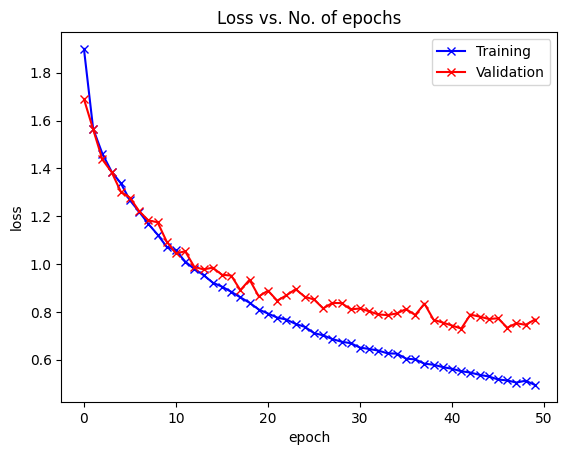

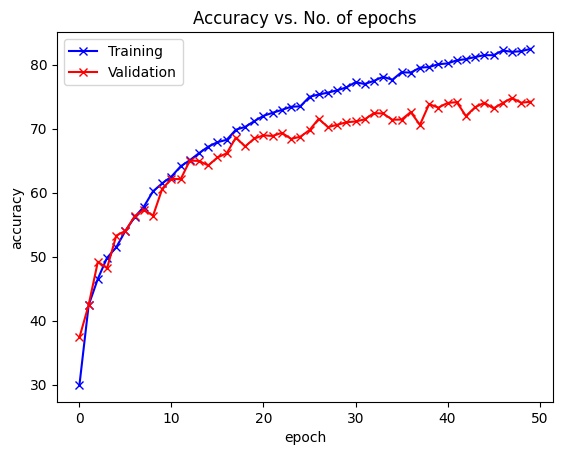

Test Loss: 0.7582, Test Accuracy: 74.53%


In [80]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)

# training model
simplecnn_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(simplecnn_results['train_loss'], simplecnn_results['val_loss'])
plot_acc(simplecnn_results['train_accuracy'], simplecnn_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {simplecnn_results["test_loss"]:.4f}, Test Accuracy: {simplecnn_results["test_accuracy"]:.2f}%')

### Train the network - Alexnet

In [71]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
alexnet_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(alexnet_results['train_loss'], alexnet_results['val_loss'])
plot_acc(alexnet_results['train_accuracy'], alexnet_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {alexnet_results["test_loss"]:.4f}, Test Accuracy: {alexnet_results["test_accuracy"]:.2f}%')

Model will be saved to: ./cifar10_alexnet.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 103/103 [00:02<00:00, 49.16it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model improved and saved to ./cifar10_alexnet.pth
Epoch 1/50, Train Loss: 1.9815, Train Acc: 23.93%, Val Loss: 1.7194, Val Acc: 32.93%, Time: 16.05s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 56.92it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 2/50, Train Loss: 1.6516, Train Acc: 36.81%, Val Loss: 1.5727, Val Acc: 40.46%, Time: 14.91s


Training:  93%|█████████▎| 382/410 [00:11<00:00, 32.43it/s]


KeyboardInterrupt: ignored

### Train the network - Resnet18

Model will be saved to: ./cifar10_resnet18.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.52it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 1/15, Train Loss: 1.7138, Train Acc: 35.94%, Val Loss: 1.6623, Val Acc: 40.25%, Time: 17.90s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 59.00it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 2/15, Train Loss: 1.4010, Train Acc: 49.02%, Val Loss: 1.3507, Val Acc: 51.45%, Time: 17.60s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 51.47it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 3/15, Train Loss: 1.2041, Train Acc: 56.71%, Val Loss: 1.1099, Val Acc: 59.32%, Time: 18.30s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 55.78it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 4/15, Train Loss: 1.0733, Train Acc: 62.04%, Val Loss: 1.0602, Val Acc: 63.01%, Time: 17.97s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 37.59it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 5/15, Train Loss: 0.9732, Train Acc: 65.48%, Val Loss: 0.9494, Val Acc: 67.07%, Time: 18.87s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.69it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 6/15, Train Loss: 0.9016, Train Acc: 68.11%, Val Loss: 0.9095, Val Acc: 67.68%, Time: 17.89s


Evaluating: 100%|██████████| 103/103 [00:02<00:00, 43.82it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 7/15, Train Loss: 0.8286, Train Acc: 70.77%, Val Loss: 0.8066, Val Acc: 72.05%, Time: 18.64s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 59.04it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 8/15, Train Loss: 0.7590, Train Acc: 73.47%, Val Loss: 0.7274, Val Acc: 74.28%, Time: 18.31s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 57.90it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 9/15, Train Loss: 0.6971, Train Acc: 76.12%, Val Loss: 0.7088, Val Acc: 75.56%, Time: 18.14s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 57.80it/s]


Epoch 10/15, Train Loss: 0.6591, Train Acc: 77.27%, Val Loss: 0.7347, Val Acc: 73.70%, Time: 18.59s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 59.24it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 11/15, Train Loss: 0.6264, Train Acc: 78.63%, Val Loss: 0.6425, Val Acc: 77.60%, Time: 18.18s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.12it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 12/15, Train Loss: 0.5784, Train Acc: 80.06%, Val Loss: 0.5963, Val Acc: 79.34%, Time: 18.79s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.75it/s]


Epoch 13/15, Train Loss: 0.5420, Train Acc: 81.25%, Val Loss: 0.6317, Val Acc: 78.55%, Time: 18.16s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 52.56it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 14/15, Train Loss: 0.5232, Train Acc: 81.86%, Val Loss: 0.5703, Val Acc: 80.90%, Time: 18.85s


Evaluating: 100%|██████████| 103/103 [00:01<00:00, 58.18it/s]


Epoch 15/15, Train Loss: 0.4900, Train Acc: 82.88%, Val Loss: 0.5989, Val Acc: 79.80%, Time: 18.17s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 69.44it/s]


Test Loss: 0.6399, Test Acc: 79.94%


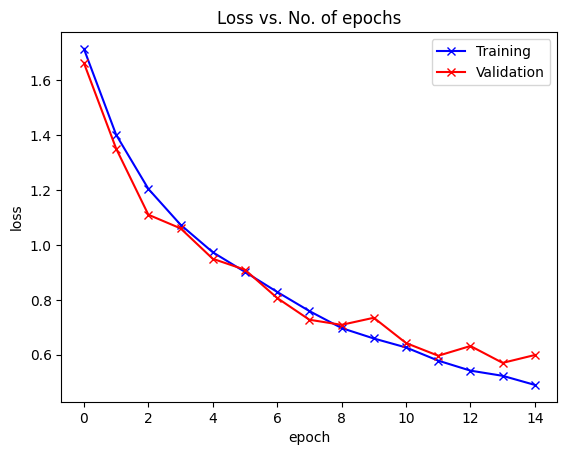

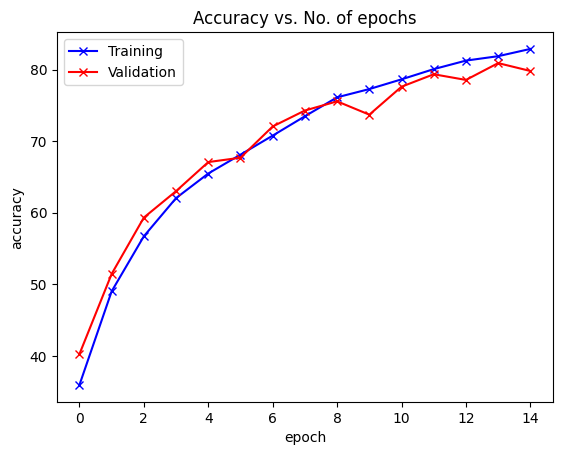

Test Loss: 0.6399, Test Accuracy: 79.94%


In [59]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet18_results['train_loss'], resnet18_results['val_loss'])
plot_acc(resnet18_results['train_accuracy'], resnet18_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {resnet18_results["test_loss"]:.4f}, Test Accuracy: {resnet18_results["test_accuracy"]:.2f}%')

### Train the network - Resnet34

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.49it/s]


Epoch 1/15, Train Loss: 1.5160, Train Acc: 44.35%, Test Loss: 1.1076, Test Acc: 59.77%, Time: 51.66s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.08it/s]


Epoch 2/15, Train Loss: 1.0284, Train Acc: 63.54%, Test Loss: 0.9513, Test Acc: 67.09%, Time: 51.74s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.11it/s]


Epoch 3/15, Train Loss: 0.7994, Train Acc: 71.87%, Test Loss: 0.7032, Test Acc: 75.56%, Time: 51.60s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.33it/s]


Epoch 4/15, Train Loss: 0.6581, Train Acc: 77.31%, Test Loss: 0.5645, Test Acc: 80.59%, Time: 51.46s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.35it/s]


Epoch 5/15, Train Loss: 0.5689, Train Acc: 80.18%, Test Loss: 0.5530, Test Acc: 81.22%, Time: 51.30s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.35it/s]


Epoch 6/15, Train Loss: 0.5023, Train Acc: 82.54%, Test Loss: 0.4969, Test Acc: 83.09%, Time: 51.67s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.72it/s]


Epoch 7/15, Train Loss: 0.4509, Train Acc: 84.48%, Test Loss: 0.4483, Test Acc: 84.87%, Time: 51.30s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.30it/s]


Epoch 8/15, Train Loss: 0.4074, Train Acc: 85.90%, Test Loss: 0.4699, Test Acc: 84.55%, Time: 51.41s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 79.45it/s]


Epoch 9/15, Train Loss: 0.3666, Train Acc: 87.31%, Test Loss: 0.4067, Test Acc: 86.21%, Time: 51.69s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.17it/s]


Epoch 10/15, Train Loss: 0.3383, Train Acc: 88.41%, Test Loss: 0.3907, Test Acc: 86.93%, Time: 51.47s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 77.14it/s]


Epoch 11/15, Train Loss: 0.3175, Train Acc: 88.95%, Test Loss: 0.4005, Test Acc: 86.85%, Time: 51.74s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.49it/s]


Epoch 12/15, Train Loss: 0.2928, Train Acc: 89.95%, Test Loss: 0.3559, Test Acc: 88.29%, Time: 51.72s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 79.04it/s]


Epoch 13/15, Train Loss: 0.2715, Train Acc: 90.57%, Test Loss: 0.3527, Test Acc: 88.91%, Time: 51.58s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.24it/s]


Epoch 14/15, Train Loss: 0.2485, Train Acc: 91.29%, Test Loss: 0.3115, Test Acc: 89.70%, Time: 51.61s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.91it/s]


Epoch 15/15, Train Loss: 0.2340, Train Acc: 91.95%, Test Loss: 0.3128, Test Acc: 89.82%, Time: 52.17s
Accuracy for each class
Accuracy of airplane : 88 %
Accuracy of automobile : 95 %
Accuracy of  bird : 83 %
Accuracy of   cat : 81 %
Accuracy of  deer : 91 %
Accuracy of   dog : 81 %
Accuracy of  frog : 94 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


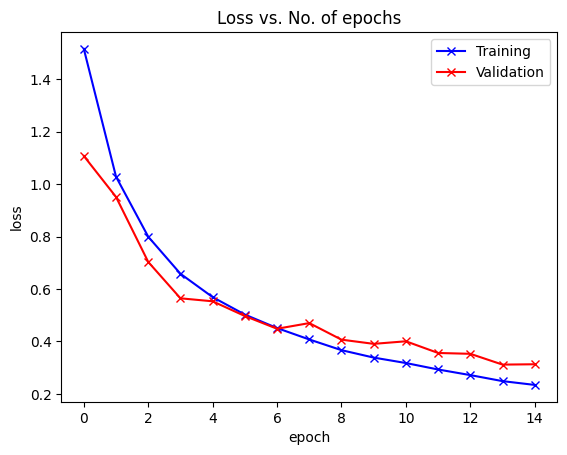

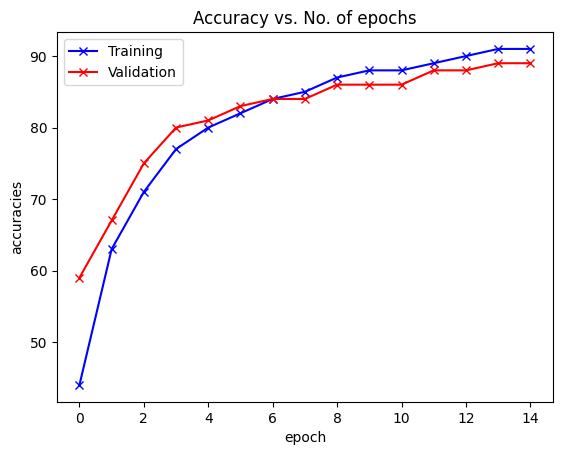

./cifar10_resnet34.pth


In [ ]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet34.state_dict(), PATH)

### Train the network - Resnet50

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.09it/s]


Epoch 1/15, Train Loss: 1.4975, Train Acc: 45.73%, Test Loss: 1.0993, Test Acc: 60.89%, Time: 62.41s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.79it/s]


Epoch 2/15, Train Loss: 0.9984, Train Acc: 64.73%, Test Loss: 1.1599, Test Acc: 63.13%, Time: 62.76s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.83it/s]


Epoch 3/15, Train Loss: 0.8039, Train Acc: 71.97%, Test Loss: 0.8211, Test Acc: 72.63%, Time: 62.78s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.48it/s]


Epoch 4/15, Train Loss: 0.6867, Train Acc: 76.23%, Test Loss: 0.6022, Test Acc: 78.82%, Time: 62.74s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.08it/s]


Epoch 5/15, Train Loss: 0.5967, Train Acc: 79.47%, Test Loss: 0.6145, Test Acc: 78.45%, Time: 62.81s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.74it/s]


Epoch 6/15, Train Loss: 0.5402, Train Acc: 81.45%, Test Loss: 0.5164, Test Acc: 82.54%, Time: 62.14s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.95it/s]


Epoch 7/15, Train Loss: 0.4894, Train Acc: 83.22%, Test Loss: 0.5136, Test Acc: 82.89%, Time: 62.64s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.23it/s]


Epoch 8/15, Train Loss: 0.4516, Train Acc: 84.48%, Test Loss: 0.4707, Test Acc: 83.82%, Time: 62.26s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.14it/s]


Epoch 9/15, Train Loss: 0.4083, Train Acc: 86.05%, Test Loss: 0.4466, Test Acc: 85.16%, Time: 62.77s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.58it/s]


Epoch 10/15, Train Loss: 0.3865, Train Acc: 86.64%, Test Loss: 0.4186, Test Acc: 86.44%, Time: 62.63s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.58it/s]


Epoch 11/15, Train Loss: 0.3637, Train Acc: 87.40%, Test Loss: 0.4241, Test Acc: 86.02%, Time: 62.83s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.85it/s]


Epoch 12/15, Train Loss: 0.3335, Train Acc: 88.54%, Test Loss: 0.3706, Test Acc: 87.67%, Time: 62.70s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.85it/s]


Epoch 13/15, Train Loss: 0.3100, Train Acc: 89.25%, Test Loss: 0.3773, Test Acc: 87.97%, Time: 62.41s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.21it/s]


Epoch 14/15, Train Loss: 0.2921, Train Acc: 89.91%, Test Loss: 0.3440, Test Acc: 88.92%, Time: 63.06s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.84it/s]


Epoch 15/15, Train Loss: 0.2784, Train Acc: 90.34%, Test Loss: 0.3434, Test Acc: 88.81%, Time: 64.53s
Accuracy for each class
Accuracy of airplane : 90 %
Accuracy of automobile : 88 %
Accuracy of  bird : 86 %
Accuracy of   cat : 77 %
Accuracy of  deer : 91 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %


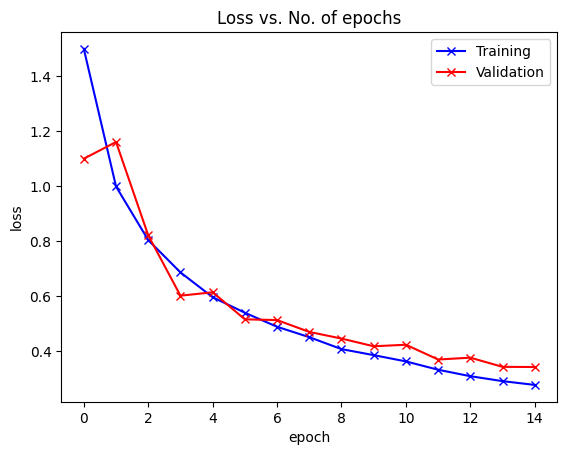

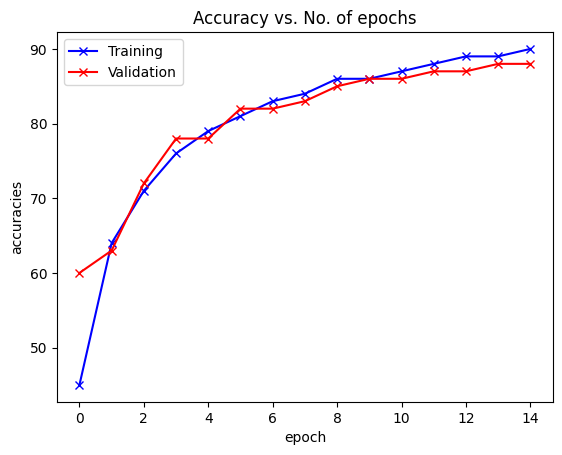

./cifar10_resnet50.pth


In [ ]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet50_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet50_results[0], resnet50_results[2])
plot_acc(resnet50_results[1], resnet50_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet50.state_dict(), PATH)

## Load the Model

In [ ]:
# net = Net()
# net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load(f'./{dataset}_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load(f'./{dataset}_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load(f'./{dataset}_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load(f'./{dataset}_resnet34.pth'))

resnet50 = ResNet50()
resnet50.load_state_dict(torch.load(f'./{dataset}_resnet50.pth', map_location=device))

<All keys matched successfully>